In [219]:
import sys
sys.path.append('../../')

# import os
import torch
from torch.utils.data import Dataset, DataLoader
import skimage
import matplotlib.pyplot as plt
from pathlib import Path
import warnings
warnings.filterwarnings("ignore")

In [220]:
from fastai import *
from fastai.vision import *
from fastai.callbacks import *

In [221]:
gpu_id = 2
num_cores = 4
torch.cuda.set_device(gpu_id)

In [222]:
bs = 8  # batch size
size = 256  # image size
data_pth = Path('/home/alaa/Dropbox/BPHO Staff/USF')  # path to dataset
hr_dir = f'EM/training/trainsets/hr/'

In [223]:
def _jigsaw(x, num_pieces=4):
    "Cut out `n_holes` number of square holes of size `length` in image at random locations."
    h, w = x.shape[1:]
    w_piece = int(w // np.sqrt(num_pieces))
    h_piece = int(h // np.sqrt(num_pieces))
    splits_per_dim = int(np.sqrt(num_pieces))
    pieces = torch.stack([x[:, i*h_piece:(i+1)*h_piece, j*w_piece:(j+1)*w_piece] 
                          for i in range(splits_per_dim) for j in range(splits_per_dim)])
    rand_indices = torch.randperm(num_pieces)
    shuffled_tiles = pieces[rand_indices]
    coords = [(i, j) for i in range(splits_per_dim) for j in range(splits_per_dim)]
    for tile, coor in zip(shuffled_tiles, coords):
        x.data[:, coor[0]*h_piece:(coor[0]+1)*h_piece,
          coor[1]*w_piece:(coor[1]+1)*w_piece] = tile
    return x

jigsaw = TfmPixel(_jigsaw, order=30)

In [230]:
random_jigsaw = partial(jigsaw, num_pieces=4, use_on_y=False)
tfms = [[random_jigsaw()], [random_jigsaw()]]
tfms

[[RandTransform(tfm=TfmPixel (jigsaw), kwargs={'num_pieces': 4}, p=1.0, resolved={}, do_run=True, is_random=True, use_on_y=False)],
 [RandTransform(tfm=TfmPixel (jigsaw), kwargs={'num_pieces': 4}, p=1.0, resolved={}, do_run=True, is_random=True, use_on_y=False)]]

In [231]:
def get_jigsaw_data(data_pth, hr_dir, bs, in_sz, out_sz,
                     tfms=None, num_workers=4, noise=None, max_zoom=1.1):
    src = get_jigsaw_src(data_pth, hr_dir)
    
    data = (src
                .transform(tfms, size=in_sz, resize_method=ResizeMethod.CROP, tfm_y=False)
                .transform_y(None, size=out_sz, resize_method=ResizeMethod.CROP)
                .databunch(bs=bs, num_workers=num_workers)
                .normalize(imagenet_stats, do_y=True))
    data.c = 3
    data.train_ds.tfms_y = None
    data.valid_ds.tfms_y = None
    return data

def get_jigsaw_src(data_pth, hr_dir):
    hr_tifs = data_pth/f'{hr_dir}'

    def map_to_hr(x):
        return hr_tifs/x.relative_to(hr_tifs).with_suffix(".tif")

    src = (ImageImageList
            .from_folder(hr_tifs)
            .split_by_rand_pct()
            .label_from_func(map_to_hr))
    return src

In [232]:
data = get_jigsaw_data(data_pth, hr_dir, bs, tfms=tfms,
                        in_sz=size, out_sz=size)

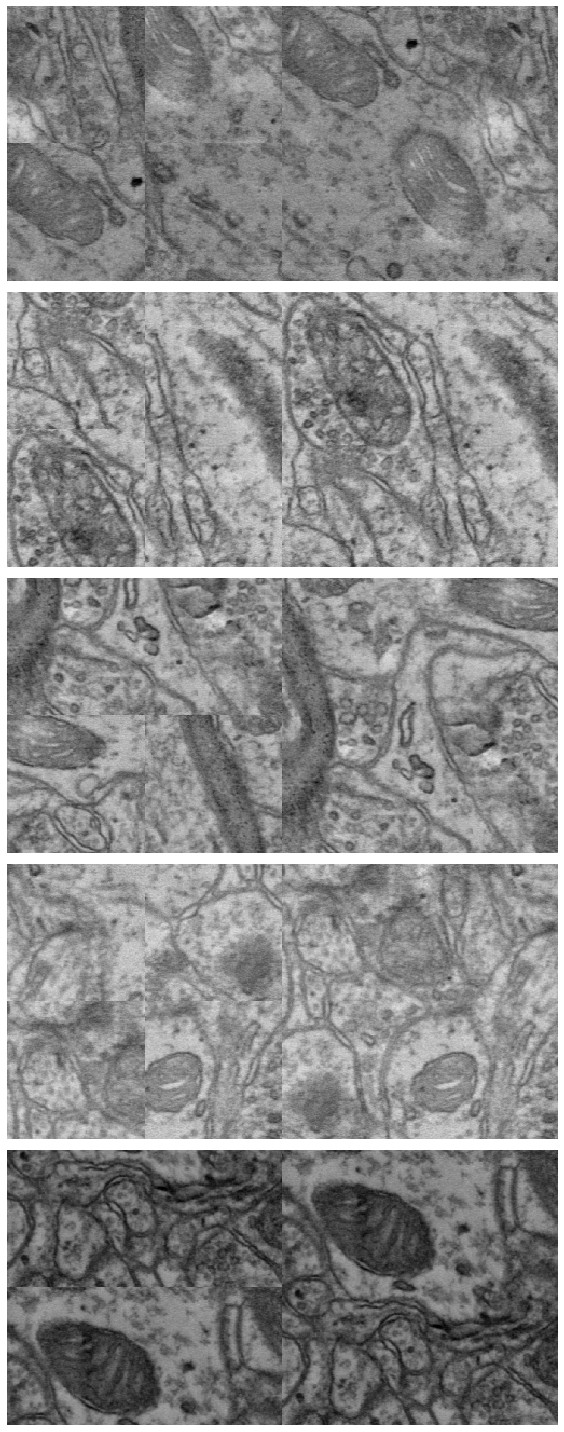

In [233]:
data.show_batch()

## DEV

In [50]:
np.arange(4)

array([0, 1, 2, 3])

In [121]:

img_list = list(data_pth.glob('*.tif'))

In [122]:
img = PIL.Image.open(img_list[0])
# img

In [123]:
img_tensor = torch.FloatTensor(np.array(img))

In [124]:
img_tensor.shape

torch.Size([600, 900, 3])

In [125]:
img_tensor = img_tensor.permute(2, 0, 1)

In [126]:
c, h, w = img_tensor.shape

In [127]:
h, w

(600, 900)

In [128]:
num_pieces = 4
w_piece = int(w // np.sqrt(num_pieces))
h_piece = int(h // np.sqrt(num_pieces))
w_piece, h_piece

(450, 300)

In [166]:
splits_per_dim = int(np.sqrt(num_pieces))
print(splits_per_dim)
pieces = torch.stack([img_tensor[:, i*h_piece:(i+1)*h_piece, j*w_piece:(j+1)*w_piece] 
                          for i in range(splits_per_dim) for j in range(splits_per_dim)])

2


In [167]:
pieces.shape

torch.Size([4, 3, 300, 450])

In [131]:
pieces.shape
# pieces

torch.Size([4, 3, 300, 450])

In [ ]:
shuffled[coor[0]*half_h:(coor[0]+1)*half_h, 
                     coor[1]*half_w:(coor[1]+1)*half_w] = piece

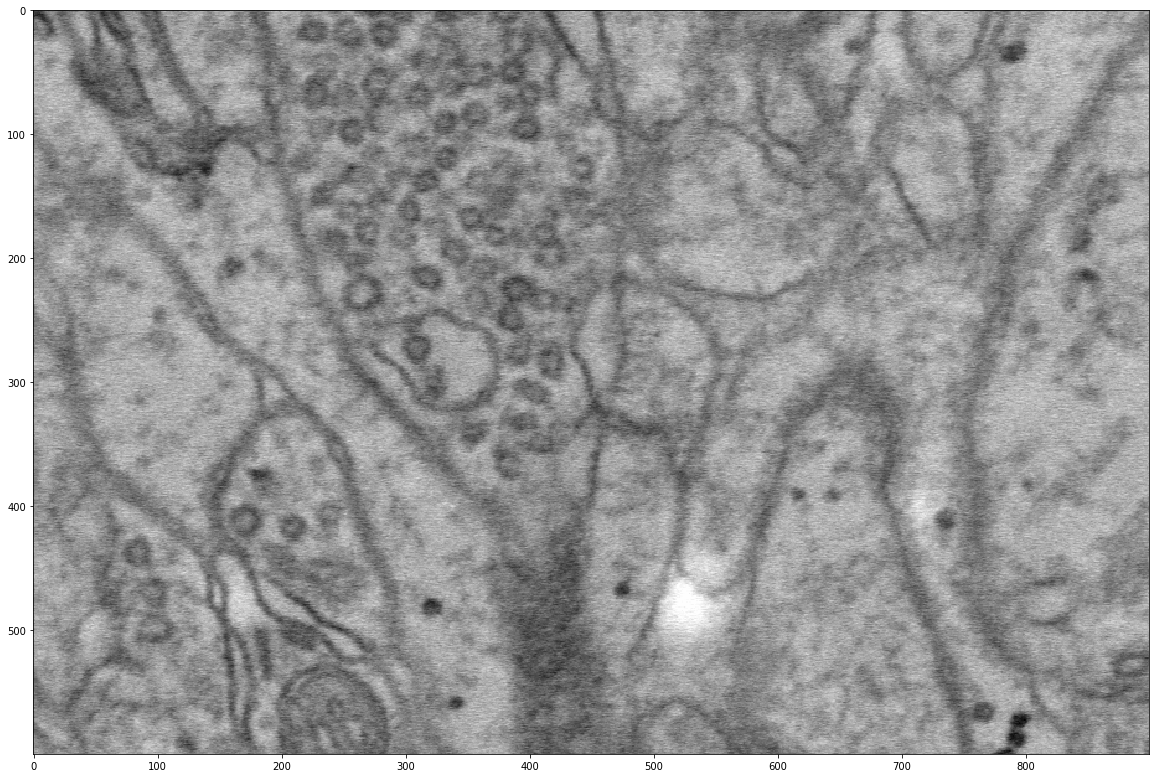

In [137]:
# pieces[rand_indices]
rand_indices = torch.randperm(4)
coords = [(i, j) for i in range(splits_per_dim) for j in range(splits_per_dim)]
for tile, coor in zip(pieces, coords):
    img_tensor.data[:, coor[0]*h_piece:(coor[0]+1)*h_piece,
               coor[1]*w_piece:(coor[1]+1)*w_piece] = tile
# shuffled_x = pieces[rand_indices].permute(1,0,2,3).reshape(-1, h, w)
plt.figure(figsize=(20,20))
plt.imshow(img_tensor.permute(1,2,0)/255)

In [95]:
rand_indices = torch.randperm(4)
shuffled_pieces = pieces[rand_indices].reshape(3, h, w)
shuffled_pieces.shape

torch.Size([3, 600, 900])

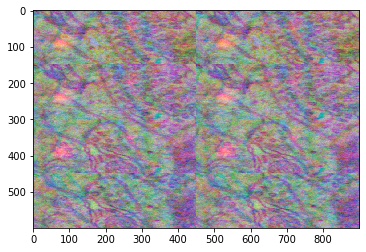

In [97]:
plt.imshow(shuffled_pieces.permute(1,2,0)/255)

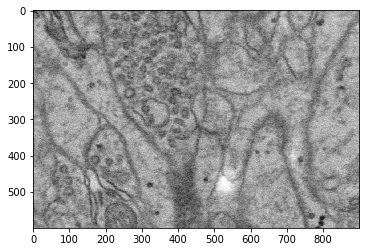

In [98]:
plt.imshow(img_tensor.permute(1, 2, 0)/255)

In [19]:
rand_indices

tensor([0, 3, 2, 1])

In [22]:
shuffled_pieces.reshape(-1, h, w).shape

torch.Size([1, 600, 900])

In [ ]:
def _jigsaw(x, num_pieces=4):
    "Cut out `n_holes` number of square holes of size `length` in image at random locations."
    h,w = x.shape[1:]
    n_holes = np.random.randint(min_n_holes, max_n_holes)
    for n in range(n_holes):
        h_length = np.random.randint(min_length, max_length)
        w_length = np.random.randint(min_length, max_length)
        h_y = np.random.randint(0, h)
        h_x = np.random.randint(0, w)
        y1 = int(np.clip(h_y - h_length / 2, 0, h))
        y2 = int(np.clip(h_y + h_length / 2, 0, h))
        x1 = int(np.clip(h_x - w_length / 2, 0, w))
        x2 = int(np.clip(h_x + w_length / 2, 0, w))
        x[:, y1:y2, x1:x2] = 0
    return x

custom_cutout = faiv.TfmPixel(_custom_cutout, order=20)

In [46]:
class EMDataSet(Dataset):

    def __init__(self, data_pth):
        self.img_list = list(data_pth.glob('*.tif'))
        
    def __len__(self):
        return len(self.img_list)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        img_name = self.img_list[idx]
        image = torch.FloatTensor(skimage.io.imread(img_name)[:,:,0])
        h, w = image.shape
        half_h, half_w = int(h/2), int(w/2)
        pieces = torch.stack([image[i*half_h:(i+1)*half_h, j*half_w:(j+1)*half_w] 
                          for i in range(2) for j in range(2)])
        indices = torch.randperm(4)
        shuffled = torch.zeros([h, w])
        for piece, coor in zip(pieces[indices], [(0,0), (0,1), (1,0), (1,1)]):
            shuffled[coor[0]*half_h:(coor[0]+1)*half_h, 
                     coor[1]*half_w:(coor[1]+1)*half_w] = piece
#         sample = {'shuffled': shuffled, 'original': image}
        self.x = shuffled
        self.y = image
        return self.x, self.y

In [47]:
jigsaw_dataset = EMDataSet(data_pth)

In [48]:
dataloader = DataLoader(jigsaw_dataset, batch_size=4,
                        shuffle=True, num_workers=4)

In [49]:
jigsaw_dataset[2]

(tensor([[159., 152., 149.,  ..., 155., 138., 133.],
         [141., 146., 137.,  ..., 177., 183., 153.],
         [126., 120., 125.,  ..., 153., 145., 148.],
         ...,
         [126., 113., 105.,  ..., 125., 112., 116.],
         [116., 124., 120.,  ..., 111., 119., 117.],
         [114., 135., 139.,  ..., 125., 130., 128.]]),
 tensor([[159., 152., 149.,  ..., 189., 184., 187.],
         [141., 146., 137.,  ..., 164., 175., 167.],
         [126., 120., 125.,  ..., 180., 195., 175.],
         ...,
         [111., 116., 118.,  ..., 138., 124., 116.],
         [141., 128., 109.,  ..., 138., 150., 156.],
         [132., 132., 128.,  ..., 156., 150., 141.]]))

In [50]:
db = DataBunch.create(train_ds=jigsaw_dataset, valid_ds=None)

In [52]:
db.one_batch()

(tensor([[[ 18.,  18.,  34.,  ..., 129., 141., 148.],
          [ 49.,  71.,  80.,  ..., 126., 134., 126.],
          [ 27.,  49.,  64.,  ..., 136., 131., 113.],
          ...,
          [ 80.,  91.,  80.,  ...,  88.,  87.,  73.],
          [ 57.,  63.,  62.,  ...,  98.,  90.,  74.],
          [111.,  94.,  77.,  ..., 121., 122., 123.]],
 
         [[144., 139., 146.,  ..., 150., 165., 168.],
          [110., 121., 134.,  ..., 153., 153., 155.],
          [122., 118., 110.,  ..., 173., 170., 171.],
          ...,
          [125., 138., 138.,  ..., 184., 157., 142.],
          [171., 157., 139.,  ..., 163., 154., 157.],
          [144., 142., 130.,  ..., 158., 143., 144.]],
 
         [[111., 121., 127.,  ..., 110., 118., 146.],
          [120., 132., 130.,  ..., 137., 147., 153.],
          [156., 155., 151.,  ..., 116., 130., 136.],
          ...,
          [146., 145., 151.,  ..., 170., 167., 179.],
          [ 90.,  85., 102.,  ..., 167., 182., 187.],
          [ 95.,  92.,  93.,  .

0 torch.Size([4, 600, 900])
1 torch.Size([4, 600, 900])
2 torch.Size([4, 600, 900])
3 torch.Size([4, 600, 900])


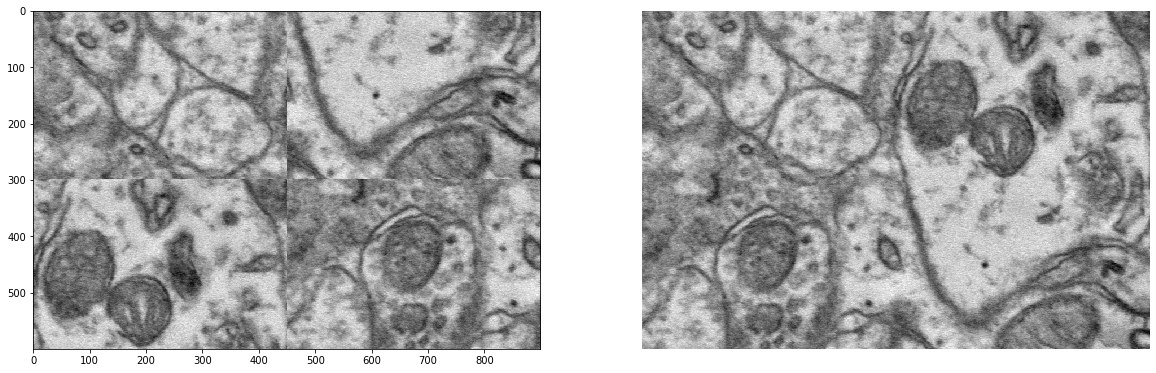

In [64]:
for i_batch, sample_batched in enumerate(dataloader):
    print(i_batch, sample_batched['shuffled'].size())

    # observe 4th batch and stop.
    if i_batch == 3:
        plt.figure(figsize=(20,20))
        plt.subplot(1,2,1)
        plt.imshow(sample_batched['shuffled'][3], cmap='gray')
        plt.subplot(1,2,2)
        plt.imshow(sample_batched['original'][3], cmap='gray')
        plt.axis('off')
        plt.ioff()
        plt.show()
        break